# Setup

In [1]:
#
# SETUP GOOGLE DRIVE
#

import os
from google.colab import drive

drive.mount('/content/drive')
print(os.getcwd(), os.listdir(os.getcwd())) #> 'content', ['.config', 'drive', 'sample_data']

DIRPATH = '/content/drive/My Drive/NeuralNetworkOpinions/Impeachment'
print(DIRPATH)
os.path.isdir(DIRPATH)

Mounted at /content/drive
/content ['.config', 'drive', 'sample_data']
/content/drive/My Drive/NeuralNetworkOpinions/Impeachment


True

In [2]:
#
# BIG QUERY CREDENTIALS
#

# google.cloud checks the file at path designated by the GOOGLE_APPLICATION_CREDENTIALS env var
# so we set it here using the shared credentials JSON file from our shared google drive
# and verify it for good measure

GOOGLE_CREDENTIALS_FILEPATH = os.path.join(DIRPATH, "credentials", "tweet-research-shared-268bbccc0aac.json") 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = GOOGLE_CREDENTIALS_FILEPATH

GOOGLE_APPLICATION_CREDENTIALS = os.getenv("GOOGLE_APPLICATION_CREDENTIALS") # implicit check by google.cloud
print(GOOGLE_APPLICATION_CREDENTIALS) # verification for implicit check
print(os.path.isfile(GOOGLE_APPLICATION_CREDENTIALS)) # verification for implicit check

/content/drive/My Drive/NeuralNetworkOpinions/Impeachment/credentials/tweet-research-shared-268bbccc0aac.json
True


In [3]:
#
# BIG QUERY SERVICE
#

from google.cloud import bigquery
from pandas import DataFrame

class BigQueryService():
    def __init__(self):
        self.client = bigquery.Client()

    def execute_query(self, sql, verbose=True):
        if verbose == True: 
            print(sql)
        job = self.client.query(sql)
        return job.result()
    
    def query_to_records(self, sql):
        rows = list(self.execute_query(sql))
        return [dict(row) for row in rows]

    def query_to_df(self, sql, verbose=True):
        records = [dict(row) for row in list(self.execute_query(sql, verbose=verbose))]
        return DataFrame(records)

    @staticmethod
    def split_into_batches(my_list, batch_size=10_000):
        """Splits a list into evenly sized batches""" 
        # h/t: https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
        for i in range(0, len(my_list), batch_size):
            yield my_list[i : i + batch_size]

    def insert_records_in_batches(self, table, records):
        """
        Inserts records in batches because attempting to insert too many rows at once 
            may result in google.api_core.exceptions.BadRequest: 400

        Params:
            table (table ID string, Table, or TableReference)
            records (list of dictionaries)
        """
        rows_to_insert = [list(d.values()) for d in records]
        #errors = self.client.insert_rows(table, rows_to_insert)
        errors = []
        batches = list(self.split_into_batches(rows_to_insert, batch_size=5_000))
        for batch in batches:
            errors += self.client.insert_rows(table, batch)
        return errors

bq = BigQueryService()

In [51]:
#
# AUC PLOTTING FUNCTION
#

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

def plot_auc(fpr: np.array, tpr: np.array, title="Receiver operating characteristic") -> None:
    """Plots the ROC characteristic and the AUC Score

        Adapted from function shared by Professor John Sipple,
        
            which was adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
        
        Args: 
            fpr: False positive rate 
            tpr: True positive rate 
        
    """

    fig, ax = plt.subplots(figsize=(10,10))
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    ax.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Fetch Bot Classifications

In [5]:
sql = f"""
    SELECT
        u.user_id
        ,u.is_bot
        ,u.is_q ,u.opinion_community
        ,u.avg_fact_score, u.avg_toxicity, u.created_on

        --bom.user_id
        ,bom.score_type as bom_score_type
        ,count(distinct bom.lookup_at) as bom_lookup_count
        ,avg(bom.cap) as bom_cap
        ,avg(bom.astroturf) as bom_astroturf
        ,avg(bom.fake_follower) as bom_fake_follower
        ,avg(bom.financial) as bom_financial
        ,avg(bom.other) as bom_other
        ,avg(bom.overall) as bom_overall
        ,avg(bom.self_declared) as bom_self_declared
        ,avg(bom.spammer) as bom_spammer
    FROM `tweet-research-shared.impeachment_2020.botometer_scores` bom 
    JOIN `tweet-research-shared.impeachment_2020.user_details_v20210806_slim` u ON bom.user_id = u.user_id -- 8683
    WHERE bom.score_type = 'english' -- 7,566 users with english scores
    GROUP BY 1,2,3,4,5,6,7,8
    -- HAVING lookup_count > 1 -- 333 users have multiple lookups, so we're going to average them instead of drop them
"""
df = bq.query_to_df(sql, verbose=False)
df.head()

,user_id,is_bot,is_q,opinion_community,avg_fact_score,avg_toxicity,created_on,bom_score_type,bom_lookup_count,bom_cap,bom_astroturf,bom_fake_follower,bom_financial,bom_other,bom_overall,bom_self_declared,bom_spammer
0,808369805094858752,True,False,0,3.235294,0.063635,2016-12-12,english,1,0.915838,0.96,0.35,0.02,0.36,0.96,0.01,0.00
1,34472721,True,False,0,3.696429,0.060307,2009-04-23,english,1,0.794672,0.54,0.30,0.37,0.47,0.40,0.07,0.01
2,1187747527,True,False,0,3.857143,0.080285,2013-02-16,english,1,0.794672,0.43,0.22,0.22,0.38,0.40,0.03,0.19
3,265461503,True,False,0,3.291667,0.065100,2011-03-13,english,1,0.882963,0.92,0.48,0.25,0.49,0.92,0.05,0.07
4,4843245081,True,False,0,2.857143,0.054542,2016-01-24,english,1,0.796622,0.62,0.43,0.32,0.62,0.62,0.07,0.05


In [20]:
# we have bimodal data (zeros and ones)
print(df["is_bot"].value_counts(normalize=True))

False    0.590272
True     0.409728
Name: is_bot, dtype: float64


In [46]:
bom_score_names = [
    "bom_cap",	
    "bom_overall",
    "bom_astroturf",
    "bom_fake_follower",
    "bom_financial",
    "bom_self_declared",
    "bom_spammer",
    "bom_other",
]

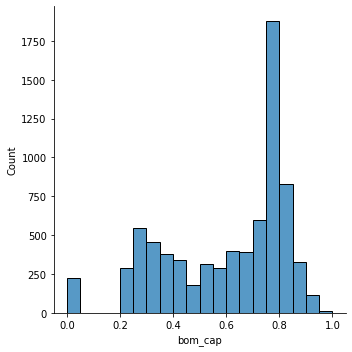

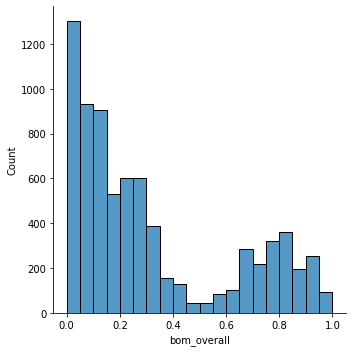

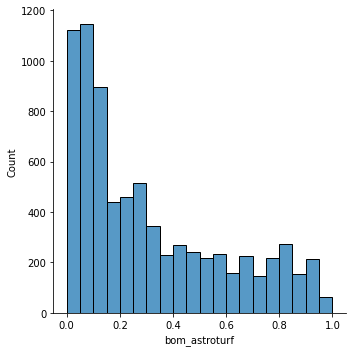

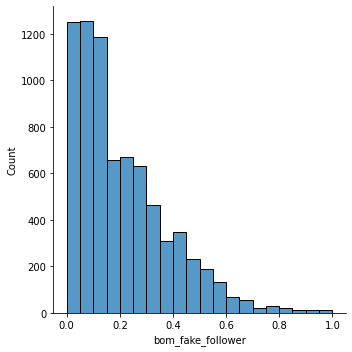

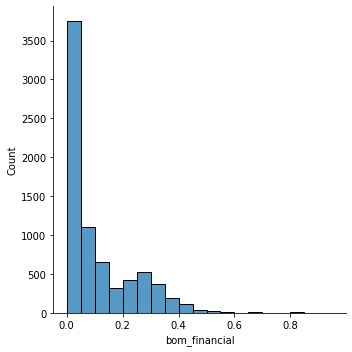

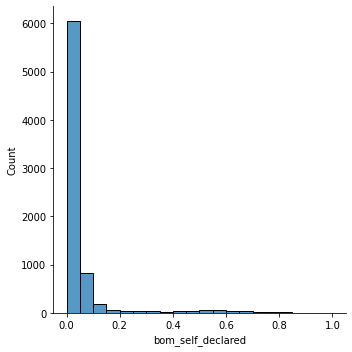

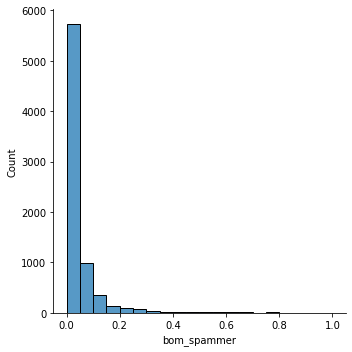

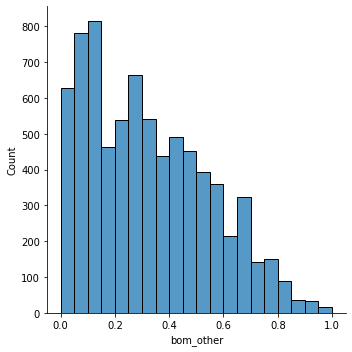

In [47]:
# https://seaborn.pydata.org/tutorial/distributions.html

from seaborn import displot

for bom_score_name in bom_score_names:

    displot(df, x=bom_score_name, binwidth=0.05) 


# ROC - AUC

In [43]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
from sklearn.metrics import roc_curve, auc

# the ROC curve function wants y param as labels of zero and one (which our scores are)
# so we'll consider our scores the y_true, and the botometer scores the y_pred
y_true = df["is_bot"]
y_pred = df["bom_astroturf"] # and/or "bom_cap" and/or "bom_astroturf"
assert y_pred.shape == y_pred.shape

fpr, tpr, thresholds = roc_curve(y_true.to_numpy(), y_pred.to_numpy()) # , pos_label=2

auc_score = auc(fpr, tpr)
print("AUC:", auc_score) #> {"bom_overall": .794, "bom_cap": 793, "bom_astroturf": .925}

AUC: 0.925896811753319


In [55]:
def calculate_auc_score(bom_score_name="bom_overall", plot=False):
    # the ROC curve function wants y param as labels of zero and one (which our scores are)
    # so we'll consider our scores the y_true, and the botometer scores the y_pred
    y_true = df["is_bot"]
    y_pred = df[bom_score_name]

    fpr, tpr, thresholds = roc_curve(y_true.to_numpy(), y_pred.to_numpy()) # , pos_label=2

    if plot:
        plot_auc(fpr, tpr, title=f"Receiver operating characteristic ('{bom_score_name.replace('bom_', '')}')")
    
    return auc(fpr, tpr)


for bom_score_name in bom_score_names:
    print("------------")
    print(bom_score_name, calculate_auc_score(bom_score_name))

------------
bom_cap 0.7936844329196944
------------
bom_overall 0.7948439463762045
------------
bom_astroturf 0.925896811753319
------------
bom_fake_follower 0.6912864943732574
------------
bom_financial 0.6862357886829521
------------
bom_self_declared 0.5472582812071132
------------
bom_spammer 0.4884244398538058
------------
bom_other 0.7502906909553183


------------


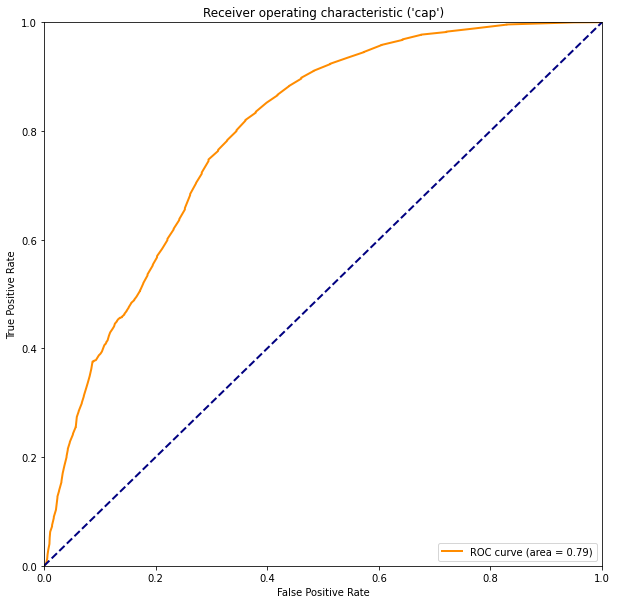

bom_cap 0.7936844329196944
------------


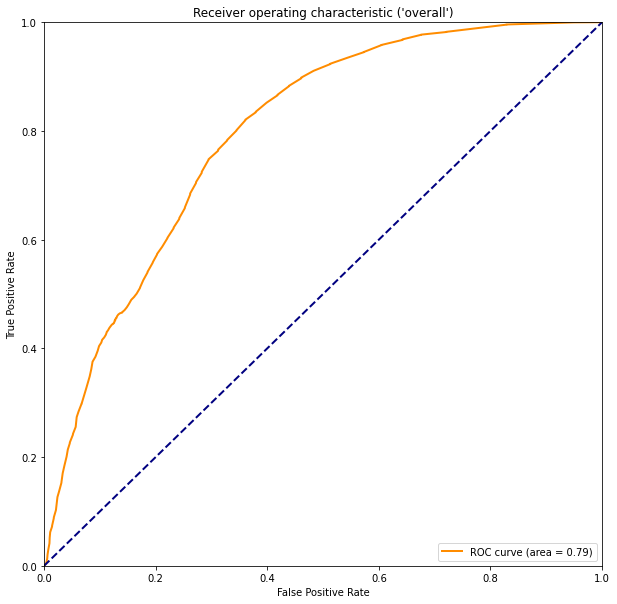

bom_overall 0.7948439463762045
------------


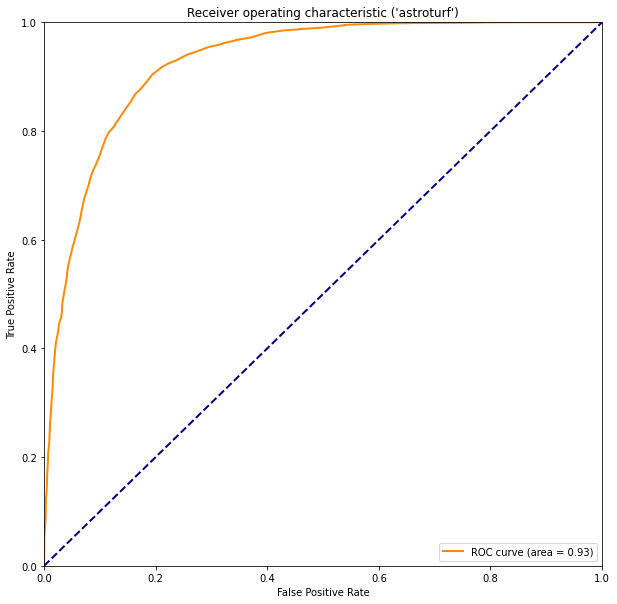

bom_astroturf 0.925896811753319
------------


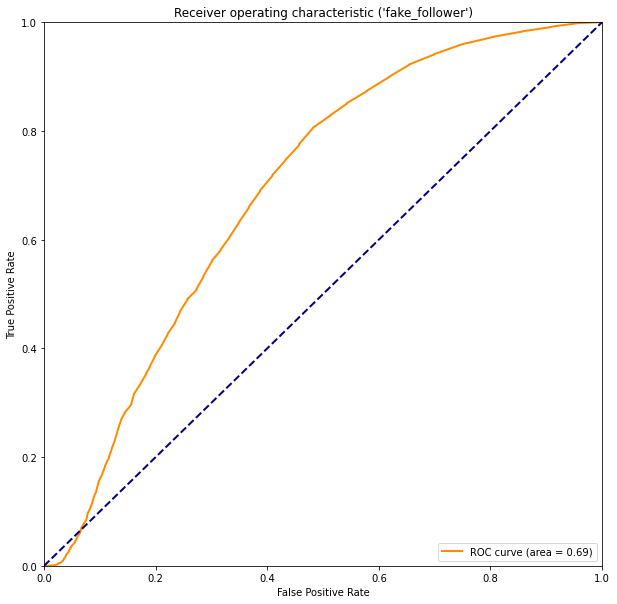

bom_fake_follower 0.6912864943732574
------------


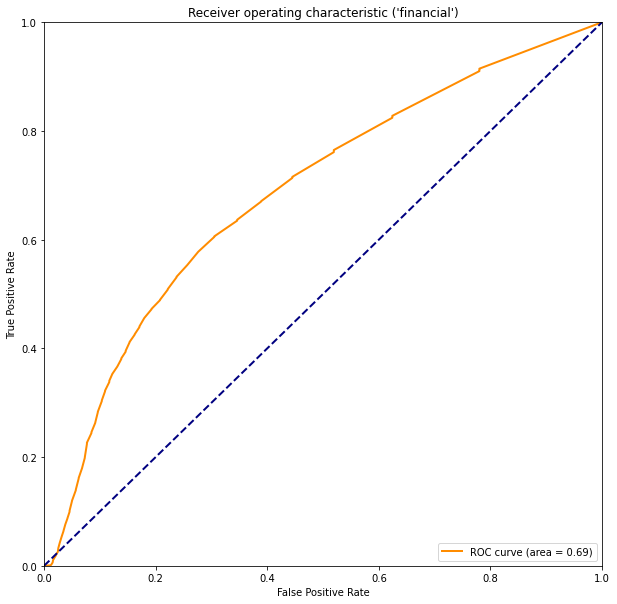

bom_financial 0.6862357886829521
------------


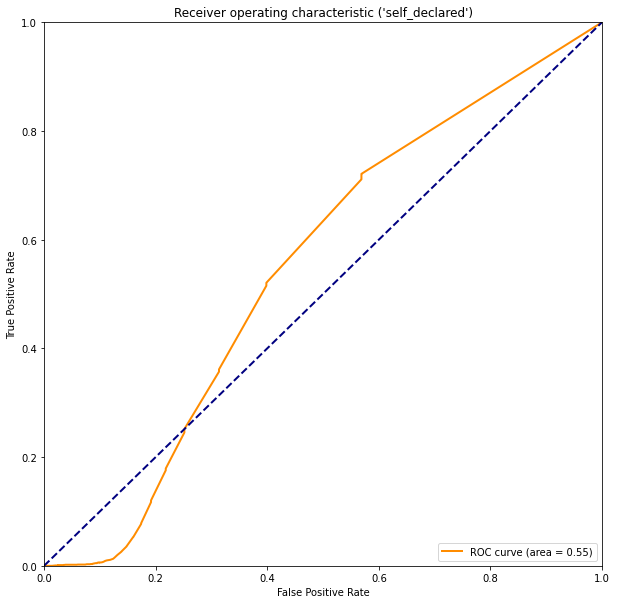

bom_self_declared 0.5472582812071132
------------


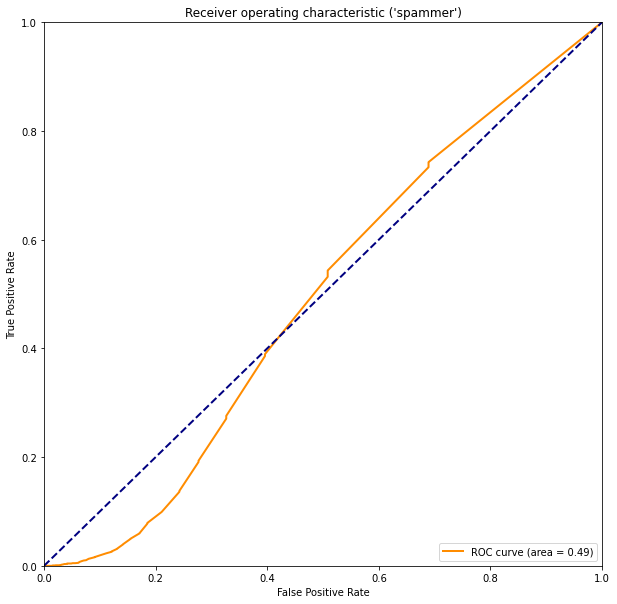

bom_spammer 0.4884244398538058
------------


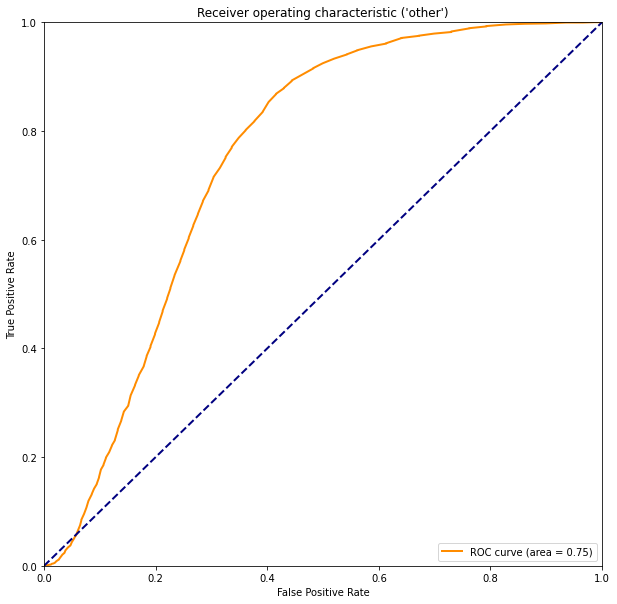

bom_other 0.7502906909553183


In [56]:

for bom_score_name in bom_score_names:
    print("------------")
    print(bom_score_name, calculate_auc_score(bom_score_name, plot=True))
